<a href="https://colab.research.google.com/github/zhengwu123/Machine_learning_group_project/blob/master/final_project_fake_real_data_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import cv2
from PIL import Image
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import numpy as np


In [0]:
!rm -rf real_main
!rm -rf real_nei
!rm -rf real_side
!rm -rf real_tongue
!rm -rf real_console
!rm -rf real_lid
!rm -rf unsorted/


In [65]:
#!ls "/content/drive/My Drive"

!unzip "/content/drive/My Drive/sorted.zip" -d "/content"

Archive:  /content/drive/My Drive/sorted.zip
   creating: /content/real_tongue/
  inflating: /content/real_tongue/RackMultipart20200503-26620-1akr951.jpg  
   creating: /content/__MACOSX/real_tongue/
  inflating: /content/__MACOSX/real_tongue/._RackMultipart20200503-26620-1akr951.jpg  
  inflating: /content/real_tongue/RackMultipart20200416-10895-9smho0.jpg  
  inflating: /content/__MACOSX/real_tongue/._RackMultipart20200416-10895-9smho0.jpg  
  inflating: /content/real_tongue/RackMultipart20200503-13017-1bdk7p6.jpg  
  inflating: /content/__MACOSX/real_tongue/._RackMultipart20200503-13017-1bdk7p6.jpg  
  inflating: /content/real_tongue/RackMultipart20200503-18464-cpyarc.jpg  
  inflating: /content/__MACOSX/real_tongue/._RackMultipart20200503-18464-cpyarc.jpg  
  inflating: /content/real_tongue/RackMultipart20200416-3289-1b3bwib.jpg  
  inflating: /content/__MACOSX/real_tongue/._RackMultipart20200416-3289-1b3bwib.jpg  
  inflating: /content/real_tongue/IMG_3039(20200416-021835).JPG  
 

In [0]:
#rename all my files
import glob, os

def rename(dir, pattern, titlePattern):
    for pathAndFilename in glob.iglob(os.path.join(dir, pattern)):
        title, ext = os.path.splitext(os.path.basename(pathAndFilename))
        os.rename(pathAndFilename, 
                  os.path.join(dir, titlePattern % title + ext))
#rename all files
rename('unsorted/real', '*.JPG', '%s'+ " real")
rename('unsorted/real', '*.jpg', '%s'+ " real")


rename('unsorted/fake', '*.JPG', '%s'+ " fake")
rename('unsorted/fake', '*.jpg', '%s'+ " fake")


In [0]:
# prepare data
import random
train_real = ['unsorted/real/{}'.format(i) for i in os.listdir("unsorted/real/") if 'real' in i]

#fake
train_fake = ['unsorted/fake/{}'.format(i) for i in os.listdir("unsorted/fake/") if 'fake' in i]

train_images = train_fake + train_real
random.shuffle(train_images)

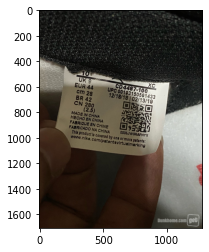

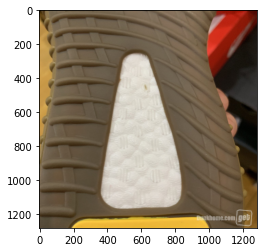

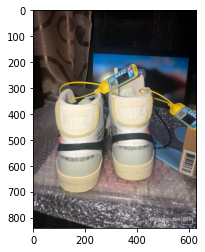

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for ima in train_images[0:3]:
  img=mpimg.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

In [0]:
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image


#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'real' in image:
            y.append(1)
        elif 'fake' in image:
          y.append(0)
    
    return X, y

In [0]:
# put traing image into x , y
X, y = read_and_process_image(train_images)
X = np.array(X)
y = np.array(y)

In [10]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (2085, 150, 150, 3)
Shape of labels is: (2085,)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import optimizers


In [0]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)
gen_flow = gen.flow(x_train,y_train, batch_size=batch_size)

In [45]:
model = Sequential()

#add conv1
model.add(Conv2D(32,(3,3),activation='relu',strides=1,padding="VALID", input_shape=(150,150,3)))
#add pool1
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#add conv2
model.add(Conv2D(64, (3, 3),strides=(3,3),activation='relu',padding="VALID"))
#add pool2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#x_train = np.array(real_image_array)
#x_test = np.array(fake_images_array)
#y_train = np.array(fake_images_array)
#y_test = np.array(y_test)
#model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
#model.fit(x_train,y_train,batch_size=100,epochs=50)
r = model.fit(gen_flow,steps_per_epoch=len(x_train) / batch_size, epochs=100)
#model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Epoch 1/100
27/26 [===============================] - 7s 258ms/step - loss: 69.5343 - accuracy: 0.5024
Epoch 2/100
27/26 [===============================] - 7s 256ms/step - loss: 0.7285 - accuracy: 0.4904
Epoch 3/100
27/26 [===============================] - 7s 258ms/step - loss: 0.6955 - accuracy: 0.5246
Epoch 4/100
27/26 [===============================] - 7s 256ms/step - loss: 0.6927 - accuracy: 0.5186
Epoch 5/100
27/26 [===============================] - 7s 255ms/step - loss: 0.6918 - accuracy: 0.5216
Epoch 6/100
27/26 [===============================] - 7s 253ms/step - loss: 0.6918 - accuracy: 0.5174
Epoch 7/100
27/26 [===============================] - 7s 255ms/step - loss: 0.6903 - accuracy: 0.5384
Epoch 8/100
27/26 [===============================] - 7s 257ms/step - loss: 0.6904 - accuracy: 0.5312
Epoch 9/100
27/26 [===============================] - 7s 256ms/step - loss: 0.6942 - accuracy: 0.5252
Epoch 10/100
27/26 [===============================] - 7s 254ms/step - loss: 0.68

In [37]:
#add data augmentation
i = Input(shape = x_train[0].shape)
x = Conv2D(32,(3,3),strides=2,activation='relu')(i)
x = Conv2D(64,(3,3),strides=2,activation='relu')(x)
x = Conv2D(128,(3,3),strides=2,activation='relu')(x)
x= Flatten()(x)
x = Dense(512,activation='relu')(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_train[:10])
model.fit(gen_flow,steps_per_epoch=len(x_train) / batch_size, epochs=20)

[1 0 1 0 0 0 0 1 0 1]
Epoch 1/20
27/26 [===============================] - 7s 259ms/step - loss: 52.3199 - accuracy: 0.5180
Epoch 2/20
27/26 [===============================] - 7s 259ms/step - loss: 0.7009 - accuracy: 0.4976
Epoch 3/20
27/26 [===============================] - 7s 260ms/step - loss: 0.6974 - accuracy: 0.4988
Epoch 4/20
27/26 [===============================] - 7s 255ms/step - loss: 0.6926 - accuracy: 0.5138
Epoch 5/20
27/26 [===============================] - 7s 254ms/step - loss: 0.6947 - accuracy: 0.5072
Epoch 6/20
27/26 [===============================] - 7s 255ms/step - loss: 0.6914 - accuracy: 0.5378
Epoch 7/20
27/26 [===============================] - 7s 254ms/step - loss: 0.6959 - accuracy: 0.5054
Epoch 8/20
27/26 [===============================] - 7s 255ms/step - loss: 0.6886 - accuracy: 0.5222
Epoch 9/20
27/26 [===============================] - 7s 255ms/step - loss: 0.6895 - accuracy: 0.5330
Epoch 10/20
27/26 [===============================] - 7s 255ms/step 

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4719104   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

[1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0
 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0
 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0
 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1
 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1
 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1
 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1
 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 0]


In [0]:
#testing ..................
test_result = model.predict(x_test)
#print(test_result.shape)
print(y_test.shape)
test_result_array = []

for i in range(len(test_result)):
  mark = 0
  for j in range(7):
    if test_result[i][j] > 0.5:
      test_result_array.append(j)
      mark = 1
      break
    if mark == 0 and j == 6:
      test_result_array.append(10)

    
count = 0
print(len(test_result_array))
for i in range(len(y_test)):
  if test_result_array[i] == y_test[i]:
    count += 1
test_accuracy = count/(len(y_test))

print("test accuracy:", test_accuracy)

(376,)
376
test accuracy: 0.5585106382978723
